In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import torch
from torch import nn

In [3]:
data=pd.read_csv('/content/bank_churn(1).csv',index_col="ID")
data.head()

,active_member,age,country,customer_id,estimated_salary,products_number,churn
ID,,,,,,,
0,1,65,2,15649992,190419.810000,2,0
1,0,53,1,15570471,47601.490156,1,1
2,0,36,0,15712536,41295.100000,2,1
3,1,29,1,15588986,9796.690000,1,0
4,0,47,1,15624137,173474.648350,1,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   active_member     600 non-null    int64  
 1   age               600 non-null    int64  
 2   country           600 non-null    int64  
 3   customer_id       600 non-null    int64  
 4   estimated_salary  600 non-null    float64
 5   products_number   600 non-null    int64  
 6   churn             600 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 37.5 KB


In [5]:
data.isna().sum()

,0
active_member,0
age,0
country,0
customer_id,0
estimated_salary,0
products_number,0
churn,0


In [6]:
data.describe()

,active_member,age,country,customer_id,estimated_salary,products_number,churn
count,600.000000,600.000000,600.000000,6.000000e+02,600.000000,600.000000,600.000000
mean,0.386667,41.448333,0.615000,1.569668e+07,100566.243514,1.411667,0.500000
std,0.487393,10.908513,0.721787,7.129012e+04,59407.396798,0.576846,0.500417
min,0.000000,20.000000,0.000000,1.556571e+07,1050.330000,1.000000,0.000000
25%,0.000000,33.000000,0.000000,1.563516e+07,51235.705000,1.000000,0.000000
50%,0.000000,41.000000,0.000000,1.570031e+07,104848.785000,1.000000,0.500000
75%,1.000000,49.000000,1.000000,1.575890e+07,155794.894228,2.000000,1.000000
max,1.000000,78.000000,2.000000,1.581504e+07,199638.560000,4.000000,1.000000


In [7]:
data['churn'].value_counts()

,count
churn,
0,300
1,300


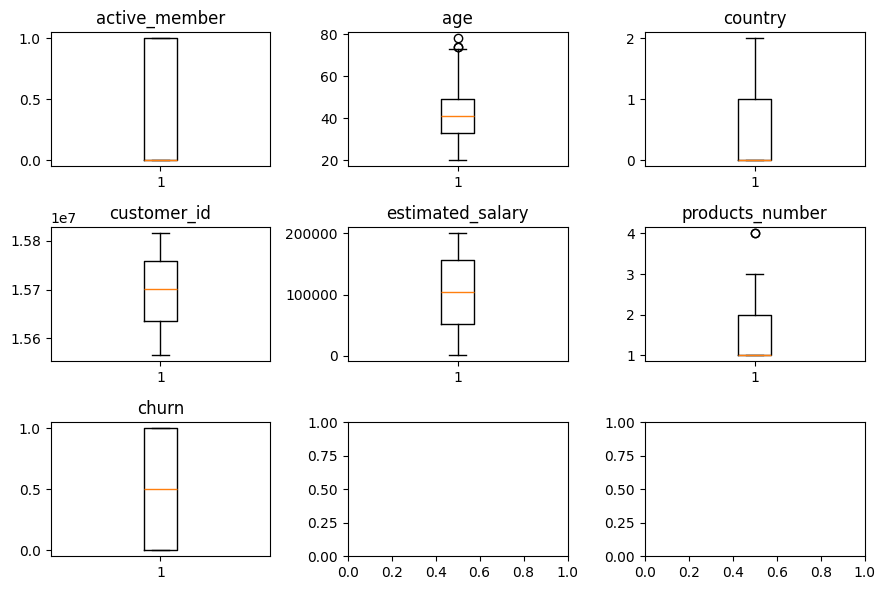

In [8]:
fig,axes=plt.subplots(3,3,figsize=(3*3,2*3))
axes=axes.flatten()
for ax,col in zip(axes,data.columns):
  ax.boxplot(data[col].dropna())
  ax.set_title(col)
plt.tight_layout()
plt.savefig("no_outliers.png")
plt.show()

In [9]:
X=data.drop(columns=['churn'])
y=data['churn'].to_numpy()

In [10]:
scaler=StandardScaler()
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [11]:
y_train.dtype

dtype('int64')

In [12]:
X_train=torch.from_numpy(X_train_scaled).float()
X_test=torch.from_numpy(X_test_scaled).float()
y_train=torch.from_numpy(y_train).float().unsqueeze(1)
y_test=torch.from_numpy(y_test).float().unsqueeze(1)

In [13]:
y_test.shape

torch.Size([120, 1])

In [14]:
class bankchurnclassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model=nn.Sequential(
        nn.Linear(6,10),
        nn.ReLU(),
        nn.Linear(10,64),
        nn.ReLU(),
        nn.Linear(64,1)
    )
  def forward(self,x):
    return self.model(x)
model=bankchurnclassifier()

In [15]:
loss_fn=torch.nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.1)

In [16]:
torch.manual_seed(42)
epochs=1000
for epoch in range(epochs):
  model.train()
  y_pred=model(X_train)
  loss=loss_fn(y_pred,y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
#now testing the model
  model.eval()
  with torch.inference_mode():
    y_eval=model(X_test)
    test_loss=loss_fn(y_eval,y_test)
  if(epoch%100==0):
    print(f"{epoch} training loss:{loss:.3f} | testing loss:{test_loss:.3f}")



0 training loss:0.711 | testing loss:0.705
100 training loss:0.555 | testing loss:0.550
200 training loss:0.490 | testing loss:0.493
300 training loss:0.448 | testing loss:0.479
400 training loss:0.420 | testing loss:0.472
500 training loss:0.401 | testing loss:0.461
600 training loss:0.387 | testing loss:0.453
700 training loss:0.376 | testing loss:0.447
800 training loss:0.367 | testing loss:0.442
900 training loss:0.359 | testing loss:0.441


In [31]:
preds=torch.sigmoid(y_eval)
y_preds=(preds>0.5).float()

In [32]:
from torchmetrics.classification import BinaryAccuracy
metric=BinaryAccuracy()
accuracy=metric(y_preds,y_test)
print(f"Accuracy of the model is {accuracy:.2f}%")

Accuracy of the model is 0.81%
